<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>

</div>

# Part 1: Score matching

# 1-1 load dataset


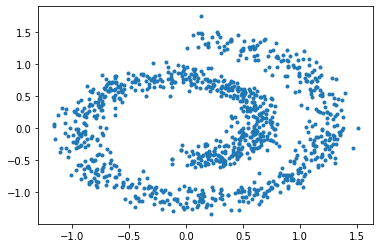

In [ ]:
import torch
from sklearn.datasets import make_swiss_roll

# generate the swiss roll dataset
xnp, _ = make_swiss_roll(1000, noise=1.0)
xtns = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)
dset = torch.utils.data.TensorDataset(xtns)

# show the samples
import matplotlib.pyplot as plt
plt.plot(xtns[:, 0], xtns[:, 1], 'C0.')

# 1-2 Neural Network for: $\mathbf{s_\theta}(\mathbf{x})$

In [ ]:
# score_network takes input of 2 dimension and returns the output of the same size
score_network = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)

# 1-3 Score Matching


Now let's implement the first and second terms of the loss function below,
$$\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{\mathbf{x}\sim p(\mathbf{x})}\left[\frac{1}{2} \left\lVert\mathbf{s_\theta}(\mathbf{x})\right\rVert^2 + \mathrm{tr}\left(\nabla_\mathbf{x} \mathbf{s_\theta}(\mathbf{x})\right)\right].
\end{equation}$$
To get the Jacobian, we can use the function from ``functorch`` or other methods.

In [ ]:
!pip install functorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from functorch import jacrev, vmap


def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    score = score_network(x)  # score: (batch_size, 2)
    # first term: half of the squared norm
    Term1 = 0.5* torch.square(torch.norm(score,dim=1))
    # second term: trace of the Jacobian
    jacobian= vmap(jacrev(score_network))(x)
    #trace
    Term2 =  jacobian.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    # return loss = first term + second term
    loss = (Term1 + Term2).sum(dim=0) / (len(x))
    return loss

In [ ]:
calc_loss(score_network,torch.randn(20,2))

tensor(-0.0116, grad_fn=<DivBackward0>)

# 1-4 Training

Everything is ready, now we can start the training.

In [ ]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size=32, shuffle=True)
t0 = time.time()
Loss =torch.zeros(1,5000)
for i_epoch in range(5000):
    total_loss = 0
    for data, in dloader:
        opt.zero_grad()


        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()
        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 500 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")

    Loss[0][i_epoch]= total_loss/len(dset)


0 (0.12025022506713867s): -2.7608480434417726
500 (53.19095015525818s): -27.74733137512207
1000 (119.35636568069458s): -38.846453063964844
1500 (181.35256814956665s): -46.68425970458984
2000 (245.04462885856628s): -53.9395703125
2500 (309.5518593788147s): -59.44367971801758
3000 (370.2073721885681s): -62.99365270996094
3500 (435.0870394706726s): -73.89459704589844
4000 (494.50369453430176s): -77.33707992553711
4500 (552.8970217704773s): -76.48500344848632


Text(0, 0.5, 'Loss')

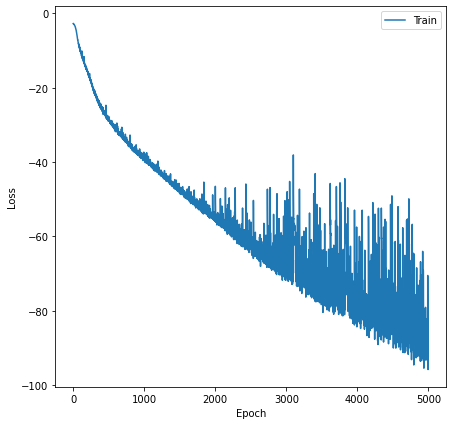

In [ ]:
# Loss curve of training samples
import matplotlib.pyplot as plt

epoch = list(range(0,5000))

f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)

plt.plot(epoch,Loss[0].detach().numpy())
plt.legend(['Train'])
plt.xlabel("Epoch")
plt.ylabel("Loss")

# 1-5 Generation

Once the neural network is trained, we can generate the samples using Langevin dynamics.

$$\begin{equation}
    \mathbf{x}_{i + 1} = \mathbf{x}_i + \varepsilon \nabla_\mathbf{x}\mathrm{log}\ p(\mathbf{x}) + \sqrt{2\varepsilon} \mathbf{z}_i
\end{equation}$$

where $\mathbf{z}_i\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a random number sampled from the normal distribution.

In [ ]:
def generate_samples(score_net: torch.nn.Module, nsamples: int, eps: float = 0.001, nsteps: int = 1000) -> torch.Tensor:

    # generating samples using Langevin dynamics and return samples
    N = torch.distributions.Normal(0, 1)
    x= torch.randn(nsamples,2)
    for t in range(nsteps):
      z = N.sample((nsamples,2))
      x = x + eps * score_net(x) + (2*eps)**(0.5) * z

    samples = x
    return samples

In [ ]:
samples = generate_samples(score_network, 1000).detach()

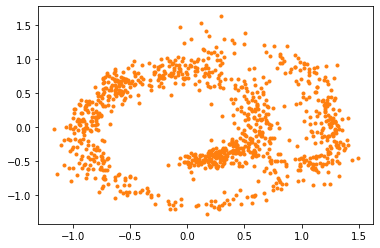

In [ ]:
plt.plot(samples[:, 0], samples[:, 1], 'C1.')

# Part 2: Denoising Score matching

# 2-1 Noise conditional Neural Network

Now let’s define the neural network that will learn the score function. This is just a simple multi-layer perceptron with LogSigmoid activation function. In contrast to the previous part, the neural network here takes n+1 inputs and produces n outputs. The additional 1 input is for the noise in $t_i$

In [ ]:
# score_network takes input of 2 + 1 (noise) and returns the output of the same size (2)
score_network = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)


In [ ]:
score_network(torch.cat( (torch.randn(5,2), torch.ones(5,1) ) , 1 ))

tensor([[0.6326, 0.1950],
        [0.6255, 0.1915],
        [0.6559, 0.2119],
        [0.6373, 0.1911],
        [0.6799, 0.2026]], grad_fn=<AddmmBackward0>)

# 2-3 Score Matching

Now let's implement the first and second terms of the loss function below,
$$\begin{equation}
\mathcal{L}(\theta) = \frac{1}{L}\sum_{i=1}^{L}{λ(σ_i)}\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x}), \mathbf{\tilde{x}}\sim q_{σ_i}(\mathbf{\tilde{x}|x})}\left[\frac{1}{2} \left\lVert\mathbf{s_\theta}(\mathbf{\tilde{x}, σ_i}) - \nabla_\mathbf{\tilde{x}} \mathbf{log q_{σ_i}}(\mathbf{\tilde{x}|x})\right\rVert^2\right]
\end{equation}$$

$$\begin{equation}
=\frac{1}{L}\sum_{i=1}^{L}\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x}), \mathbf{z}\sim\mathcal{N}(\mathbf{0}, \mathbf{I})}\left[\frac{1}{2} \left\lVert\mathbf{\sigma_i s_\theta}(\mathbf{x+σ_iz, σ_i})+ z\right\rVert^2\right] + const.
\end{equation}$$


In [ ]:
L=1000
sigmas = torch.linspace(0.001, 0.04, steps=L)


def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data

    # sample the time
    t=torch.randint(1,L,(len(x),1))

    #computing denoising score matching L
    z = torch.distributions.Normal(0, 1).sample(x.shape)
    x_tild = x + sigmas[t]*z

    arg = torch.cat( ( x_tild , sigmas[t] ) , 1)
    a = sigmas[t] * score_network( arg ) + z
    loss = 0.5* torch.square(torch.norm(a))/len(x)

    return loss

# 2-4 Training

Everything’s ready, so we can start the training. It takes about 20 - 25 minutes to complete the training.

In [ ]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size=256, shuffle=True)
t0 = time.time()
Loss =torch.zeros(1,150000)
for i_epoch in range(150000):
    total_loss = 0
    for data, in dloader:
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 10000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")

    Loss[0][i_epoch]= total_loss/len(dset)

0 (0.7201588153839111s): 1.0117065925598145
10000 (128.83313584327698s): 1.0068708972930909
20000 (313.3059446811676s): 1.0052996277809143
30000 (504.0176033973694s): 0.9949423122406006
40000 (677.710607290268s): 0.9980998902320862
50000 (846.9566190242767s): 1.007366792678833
60000 (1013.1259231567383s): 0.9817939634323121
70000 (1180.6887753009796s): 1.0194600734710693
80000 (1345.3181438446045s): 0.9239228491783142
90000 (1509.3989899158478s): 0.965563687801361
100000 (1672.6901593208313s): 0.9972975587844849
110000 (1833.2745380401611s): 0.9072104897499085
120000 (1992.9031732082367s): 1.0065376615524293
130000 (2152.313666820526s): 1.0462466869354248
140000 (2316.244733572006s): 0.9538765053749084


Text(0, 0.5, 'Loss')

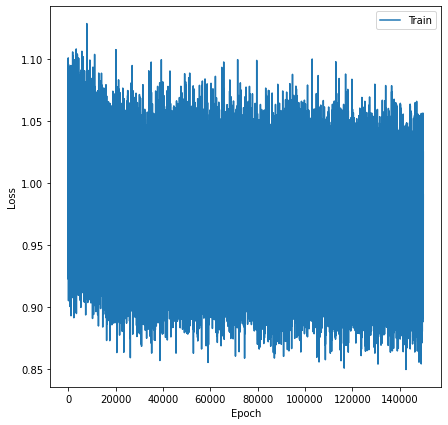

In [ ]:
# Loss curve of training samples
import matplotlib.pyplot as plt

epoch = list(range(0,150000))

f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)

plt.plot(epoch,Loss[0].detach().numpy())
plt.legend(['Train'])
plt.xlabel("Epoch")
plt.ylabel("Loss")

# 2-5 Generation

Once the neural network is trained, we can generate the samples using Annealed Langevin dynamics.

$$\begin{equation}
    \mathbf{x}_{i + 1} = \mathbf{x}_i + \frac{α_i}{2}\mathbf{s_\theta}(\mathbf{x+σ_iz, σ_i}) + \sqrt{\alpha_i}\mathbf{z}_i
\end{equation}$$

where $\mathbf{z}_i\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a random number sampled from the normal distribution.

and $\mathbf{α_i=ϵ.\frac{σ_i}{σ_L}}$




In [ ]:
L=1000
sigmas = torch.linspace(0.001, 0.04, steps=L)

def generate_samples(score_network: torch.nn.Module, nsamples: int, eps: float = 0.001, nsteps: int = 1000) -> torch.Tensor:

    # generating samples using Annealed Langevin dynamics and return samples
    N = torch.distributions.Normal(0, 1)
    x= torch.randn(nsamples,2)
    for i in range(L):
      alpha = eps * (sigmas[i]/sigmas[L-1])**2
      for t in range(nsteps):
        z = N.sample((nsamples,2))
        x = x + (alpha/2) * score_network( torch.cat( ( x , sigmas[i]*torch.ones(len(x),1) ) , 1 ) )  + (alpha)**(0.5) * z

    samples = x
    return samples

In [ ]:
samples = generate_samples(score_network, nsamples=1000,nsteps=2 ).detach()

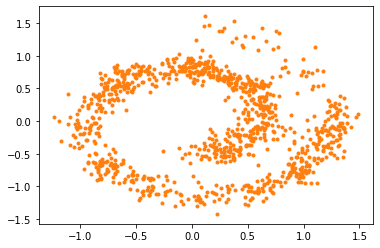

In [ ]:
plt.plot(samples[:, 0], samples[:, 1], 'C1.')